# Reading data from  a file


When working with online learning, data is expected to arrive and be processed by our model as a stream. However, it  is typical to use file-based  datasets to develop our base  model before deploying into an online  production environment. In the previous Labs, the examples we studied used datasets already included in  the River library. Because these datasets are provided by the library developers, they illustrate ideally the characteristics of the algorithms and methods desired of the example. However, we will usually need to load our own datasets. River provides different data connector modules to obtain data from different source types, including CSV files.   To create a proactive datastream from these files,  the River connectors produce generator objects that, when used in an iterator, act as data streams to feed our online models.


In this example,  we shall obtain data from a CSV file, exploring different aspects of the process. For this,  the  well-known Titanic dataset will be used.  It can be downloaded from the [Kaggle](https://www.kaggle.com/c/titanic/data) repository.  Here, we shall focus primarily on data input and processing of this data file, so that the model accuracy and performance are secondary.

It must be noted that many other preprocesing operations can be done to enhance the performance of a machine learning model in predicting survival chances aboard the Titanic. This notebook only shows some examples in order to demonstrate how to apply different operations with River

Even though the online learning scenario differs from that of batch learning, we still need to know input data structure in order to adapt it to our model.  The data structure of the Titanic dataset in the form of a dictionary can be found on the repository (see [Kaggle web page](https://www.kaggle.com/c/titanic/data)).


### First step:  

Load the dataset with Pandas to check data fields and characteristics: 

In [ ]:
import pandas as pd
dataset_path="./datasets/titanic.csv" #you must change this var whether the dataset is in another path
data=pd.read_csv(dataset_path)
print(data.head())
print(data.dtypes)
print(data.describe())


Although  River already has a connector to iterate from Pandas DataFrame, for illustrative purposes,  here we shall use [one](https://riverml.xyz/0.14.0/api/stream/iter-csv/) that is  linked to CSV files.

<code>iter_csv</code> creates a Python iterator. Each time we use `next` we get a new observation consisting  of a set of both inputs and outputs


In [ ]:
from river import stream
from rich import print
titanic = stream.iter_csv(dataset_path)
sample, target = next(titanic)
print(sample)
print(target)

There is no way to know which sample attributes are targets, so each one is loaded as an input. However, the  target attribute names must be specified.

In [ ]:
titanic = stream.iter_csv(dataset_path, target="Survived")
sample, target = next(titanic)
print("###Inputs###")
for key, value in sample.items():
    print(f"{key}={value}")
print("###Targets###")
print(f"Survived: {target} - {'yes' if target==1 else 'no'}")

## Numerical and categorical (nominal) attributes

When using a River connector, by default, all the loaded attributes are interpreted as strings (categorical attributes).   Therefore, `converters` [parameters](https://riverml.xyz/0.21.0/api/stream/iter-csv/) are used to modify the behavior and assign a specific type to each attribute, referred to as casting. Also,  (lambda) functions can be used to  *convert* the value of the attributes


* converters.  Type &rarr; dict | None

All values in the CSV are interpreted as strings by default. You can use this parameter to cast values to the desired type. This should be a dict mapping feature names to callables used to parse their associated values. Note that a callable may be a type, such as float and int.
    
Note that the `convert` functions are executed for each iterator call. If there is a problem in the data conversion of a specific attribute (for example the field is null and cannot be cast), it will produce an exception error.  Considering that data is not loaded at the beginning, but one by one by the iterator, exceptions could be thrown at any moment in the loop.   

For example, consider the following:  a `float` converter is assigned to the type of the *Age* attribute, however, in the Titanic dataset,  there are some records that don’t contain *Age* information.  In this case,  since a null cannot be cast to float, a ValueError exception will be throw when an empty *Age* value appears.  For this, a function (`float_converter`) for dealing with bad type conversions is used.  Another possibility is to use the `drop_nones` parameter to remove the attributes with None values that we inserted during the data type conversion process.

Often, some fields in a dataset are not useful for the purpose of predictions. Thus, they don’t contain useful information to improve a model's performance.   In these cases,  they can be dropped when the dataset is loaded or removed in future pipeline steps.   This is done with the following command: 


* drop. Type &rarr; List[str] | None

 

In [ ]:
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #return 1 if the passenger had a cabin. Otherwise 0
    


titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)



for sample, target in titanic:
    print(sample, 'Survived' if target==1 else 'Deceased')


### One hot encoding

Often, a problem can be solved using different machine learning model techniques (eg. SVM, Random Forest, etc).  However, not all the ML models can directly deal with categorical attributes. A typical solution employed is the one-hot attribute encoding. 

For this, River provides a preprocessing function to online encode categorical attributes. A very powerful feature is that this method does not need to know all the categories in advance;  instead, they are added “on the fly”.

An example with the Titanic dataset that can use this one-hot encoding funcion is the *Embarked* attribute: 


In [ ]:
from river import stream, compose, preprocessing
titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)



pp = compose.Select('Embarked') | preprocessing.OneHotEncoder(drop_zeros=False)
for sample, target in titanic:
    pp.learn_one(sample)
    print(pp.transform_one(sample))
    

#### Adding preprocessing operations to the pipeline

Now, we can put many steps together.  For this, we can create a River pipeline containing different preprocessing operations that prepare the data fields that will be inputs to the machine learning online model.   Thus, these steps will include feature engineering, one-hot encoding, feature removing, etc.

An example is shown below. 


In [ ]:
from river import stream, compose, preprocessing
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #return 1 if the passenger had a cabin. Otherwise 0

def generate_new_attributes(x):#feature enginnering
    #This feature generation can be improved. Many other interesting features can be developed
    x["FirstClass"]=1 if x["Pclass"]==1 else 0
    x["FamilyMembers"]=x["SibSp"]+x["Parch"]+1
    return x

titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)

to_discard=['SibSp','Parch','Embarked',"Pclass"]#feature removing

pp=compose.FuncTransformer(generate_new_attributes)\
            +(compose.Select('Embarked') | preprocessing.OneHotEncoder(drop_zeros=False))\
            |compose.Discard(*to_discard)
                            
    

for sample, target in titanic:
    pp.learn_one(sample)
    print(pp.transform_one(sample), 'Survived' if target==1 else 'Deceased')
    

#### Wrapping up

The following includes all the previous steps together with a ML model.  Remember, the purpose of this example is to illustrate data loading and attribute casting.  The model is secondary here and would require more effort to improve its performance.


In [ ]:
from river import stream, compose, preprocessing, evaluate, metrics
from river.tree import HoeffdingTreeClassifier
removed_attributes=['PassengerId', 'Name', 'Ticket','Fare',]
sex=lambda  g: 0 if g=="male" else 1
def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

cabin=lambda  g: 1 if g!="" else 0 #return 1 if the passenger had a cabin. Otherwise 0

def generate_new_attributes(x):#feature enginnering
    x["FirstClass"]=1 if x["Pclass"]==1 else 0
    x["FamilyMembers"]=x["SibSp"]+x["Parch"]+1
    return x

titanic = stream.iter_csv(dataset_path, target="Survived", drop_nones=True,\
                          converters={'Survived':int,'Pclass':int, 'Age':float_converter, 'SibSp':int,'Parch':int, 'Sex':sex, 'Cabin':cabin},\
                          drop=removed_attributes)

to_discard=['SibSp','Parch','Embarked',"Pclass"]#feature removing

model=compose.FuncTransformer(generate_new_attributes)\
            +(compose.Select('Embarked') | preprocessing.OneHotEncoder(drop_zeros=False))\
            |compose.Discard(*to_discard)

model|= HoeffdingTreeClassifier(grace_period=50)


print(evaluate.progressive_val_score(dataset=titanic, model=model, metric=metrics.Accuracy()))
model['HoeffdingTreeClassifier'].draw()
                            

# Concept Drift

As seen so far in our examples, stream learning requires models that can adapt over time and be trained in the progressive validation schema. This is based upon the assumption that most data can change over time. Classical machine learning models often assume that data has a stationary probability distribution, ie. one that is fixed.  However, due to its inherent nature,  stream learning often deals with data whose distribution can change. This phenomenon of changing data in the context of ML has given rise to a new term called **Concept drift**.

Concept drift can be classified into two main groups, virtual and real. In virtual concept drift, the distribution of the features changes whereas the relationship between features and target remains stable. Thus, given that  $X$ is the feature set and $y$ is the desired output, changes in $P(X)$ would be observed  but not the joint distribution $P(X,y)$, which would remain the same. On the other hand, in real concept drift, it is the joint probability, $P(X,y)$, that would vary. Such changes could be abrupt or gradual.

Several situations exemplify the potential occurrence of concept drift,  including, stock market pricing over time, electricity demand demand over time, or movie preferences of users on sites such as Netflix.  In each case, the abrupt change in the value of a parameter over time is readily imagined.  Consider, for example,  prediction systems used for stocking supermarket inventory.  If this model was trained at the beginning of the 2020 pandemic, which was biased towards face masks, hydroalcoholic gel and toilet paper,  the model would be outdated now.  Thus, over time the preferences of purchases changed and the systems should adapt to this point.


The most common approach to deal with the concept drift is the use of drift-aware callback methods that trigger mitigation mechanisms. The main objective is to raise an alarm, and/or execute some callback code, when a change in prediction performance is detected. Some methods rely upon desirable properties for the detectors, such as maximizing the number of True Positives (TP) while simultaneously retaining the (FP) to a minimum, i.e., with high precision. Additionally, such alarm methods should be efficient,  and theoretically, able to work with an infinite data stream.

Here an example composed by 5 distributions of 5,000 samples with the following properties is given to explore these ideas. 

* $dist_a:\mu=0.9, \sigma=0.01$
* $dist_b:\mu=0.8, \sigma=0.05$
* $dist_c:\mu=0.4, \sigma=0.02$
* $dist_d:\mu=0.6, \sigma=0.1$
* $dist_e:\mu=0.6, \sigma=0.01$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate data for 5 distributions
random_state = np.random.RandomState(seed=41)
dist_a = random_state.normal(0.9, 0.1, 5000)
dist_b = random_state.normal(0.8, 0.05, 5000)
dist_c = random_state.normal(0.4, 0.02, 5000)
dist_d = random_state.normal(0.6, 0.1, 5000)
dist_e = random_state.normal(0.6, 0.01, 5000)

# Create out synthetic data stream
stream = np.concatenate((dist_a, dist_b, dist_c, dist_d, dist_e))

# Auxiliary function to analyse the data
def plot_data(stream, dists, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    for id, dist in enumerate(dists):
        ax2.hist(dist, label=f'dist_{id}')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(stream, [dist_a, dist_b, dist_c, dist_d, dist_e])

Here, we study an example of a concept drift detector, called Adaptative WINdowing (ADWIN). The objective of this method is to determine when a change in the properties of the data stream occurs, by using a moving window that adapts to variations.  As such, it seeks to detect variations at different scales.  

The method is based upon a sliding window that monitors the statistics of incoming data and detects changes in the distribution over time. The algorithm maintains two sets of statistics: the statistics of the current window and the statistics of the historical data. When a change in the distribution is detected, the current window is updated and the historical data is forgotten. The size of the window is adaptively adjusted based on the rate of change in the data. The ADWIN algorithm is computationally efficient, with a time complexity of O(log n) per data point, where n is the number of data points processed so far.

In [ ]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)

plot_data(stream, [dist_a, dist_b, dist_c, dist_d, dist_e], drifts)

As we can see, this method has  identified 3 out of 4 drifts.   Note, that if the change is gradual,  the window is larger and thus,  requires more steps to identify that change. In this particular case, it will require nearly 500 samples to become aware of the change in the data.

However, ask yourself:  why hasn’t the method raised an alarm in the last change? The answer is because it is not a drift.   Recall that a drift is a change in the relation between data and target;  in this case,  there is no such because the average is the same. This raises an important caveat for such detectors:  they can only be used for univariate data. That is the reason why they are used to monitor a model's performance and not the data itself.


### Play with River

There are other drift detectors that can be used.  Two such detectors that you can study and test with the same dataset are the following: 
* [The Kolmogorov-Smirnov Windowing method](https://riverml.xyz/latest/api/drift/KSWIN/) 
* [The Page-Hinkley method](https://riverml.xyz/latest/api/drift/PageHinkley/) 

Care must be used with the first of these since it is very sensitive to the alpha parameter. Try it with $10^{-5}$. 


Change detected at index 5549

Change detected at index 10126

Change detected at index 15254

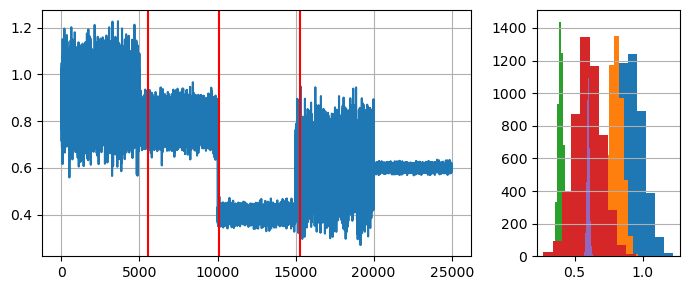

In [28]:
#Play with River

#The Kolmogorov-Smirnov Windowing method

from river import drift
#drift_detector = drift.KSWIN(alpha=0.0001, seed=42)
drift_detector = drift.PageHinkley()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)

plot_data(stream, [dist_a, dist_b, dist_c, dist_d, dist_e], drifts)




### Concept Drift based in the error rate

Other concept drift detection methods exist that are based on the learning model premise, namely, that the learner's error rate will decrease as the number of analyzed samples increase, as long as the data distribution is stationary.   In this case,  if the algorithm detects that the increase in the error rate exceeds a certain threshold, a warning or callback is triggered. 

Given that these methods are based on the error rate, we can simulate a sequence of prediction results, where **'1' means that the model failed and '0' that the model was successful**. In a real world problem this information would be directly obtained from the model results once it gets the true label. 

Next, by using our simulated stream, we can test the **Drift Detection Method** (DDM), that is part of these binary methods.

The DDM method has two thresholds. Once the stream of results exceeds the first threshold, the algorithm will warn the user that a change may occur in the near future (warning zone). Once the second threshold is surpassed the algorithm confirms the change and it resets its memory in order to continue detecting new changes.


In [29]:
#We are simulating the performance's model decay over the time. There are 2 abrupt drifts 
import random 
random.seed(1234)
good_results=random.choices([0,1],  weights=[0.8, 0.2], k=1000) #Return a k sized list of elements chosen from the population [0,1] with replacement
bad_results1=random.choices([0,1], weights=[0.6, 0.4], k=1000)#The elements from the list are chosen with different probability
bad_results2=random.choices([0,1], weights=[0.2, 0.8], k=1000)
data_stream=good_results+bad_results1+bad_results2

In [30]:
from river import drift
ddm=drift.binary.DDM(warm_start=100)#We are waiting the first 100 observations before starting to analyze the drif

#We simulate the data stream with a loop
trigger_warning=True
for idx, result in enumerate(data_stream):#The enumerate methods gets and enumerate each sequence value
    ddm.update(result)
    if ddm.warning_detected and trigger_warning:
        print(f"Warning detected at index {idx}")
        trigger_warning=False#once the threshod is overpassed, it is usually overpassed  during many iterations
    if ddm.drift_detected:
        print(f"A drift was detected at index {idx}")
        trigger_warning=True
    

Warning detected at index 1077

A drift was detected at index 1151

Warning detected at index 1720

A drift was detected at index 2058

### Play with River
There are other 3 binary drift detection methods in River.  You should study each and test them with the datastream: 
* [EDDM](https://riverml.xyz/latest/api/drift/binary/EDDM/)
* [HDDM_A](https://riverml.xyz/latest/api/drift/binary/HDDM-A/)
* [HDDM_W](https://riverml.xyz/latest/api/drift/binary/HDDM-W/)

Note, the interface for each method is exactly the same, so you can re-use the code or work with several detectors in parallel. Nonetheless, drift detectors rely upon internal hyperparameters, so their default configurations may not be the optimal for your problem.


Warning: the parameters to initialize each detector are different. You should check the available parameters carefully.


In [33]:
#Play with River


from river import drift
#detector=drift.binary.DDM(warm_start=100)#We are waiting the first 100 observations before starting to analyze the drif
#detector=drift.binary.EDDM(warm_start=100, alpha=0.8, beta=0.7)
detector=drift.binary.EDDM(warm_start=100, alpha=0.8, beta=0.7)

#We simulate the data stream with a loop
trigger_warning=True
for idx, result in enumerate(data_stream):#The enumerate methods gets and enumerate each sequence value
    detector.update(result)
    if detector.warning_detected and trigger_warning:
        print(f"Warning detected at index {idx}")
        trigger_warning=False#once the threshod is overpassed, it is usually overpassed  during many iterations
    if detector.drift_detected:
        print(f"A drift was detected at index {idx}")
        trigger_warning=True


Warning detected at index 1227

A drift was detected at index 1696

Warning detected at index 2087

A drift was detected at index 2208